In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [2]:
# import warnings
# warnings.filterwarnings("default")

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]=="Ext"]

obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_1"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_2"]
obj = obj[obj.obs["Cell sub annotation"]!="Ext_Unk_3"]

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2487: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 12598 cells


In [9]:
new_sub_annotation = []
for c in obj.obs["Cell sub annotation"].tolist():
    if c in ['Ext_Amy_1', 'Ext_Amy_2']:
        new_sub_annotation.append('Ext_Amy')
        
    elif c in ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3']:
        new_sub_annotation.append('Ext_Hpc_CA')
        
    elif c in ['Ext_Hpc_DG1', 'Ext_Hpc_DG2']:
        new_sub_annotation.append('Ext_Hpc_DG')
        
    elif c in ['Ext_L5_1', 'Ext_L5_2', 'Ext_L5_3']:
        new_sub_annotation.append('Ext_L5')
        
    elif c in ['Ext_Thal_1', 'Ext_Thal_2']:
        new_sub_annotation.append('Ext_Thal')
        
    else:
        new_sub_annotation.append(c)
obj.obs["Cell sub annotation"] = new_sub_annotation
obj.obs["Cell sub annotation"] = obj.obs["Cell sub annotation"].astype("category")

Trying to set attribute `.obs` of view, copying.


#### Data preparation

In [10]:
sf.data_preparation(obj)

#### Data split

In [11]:
s = time.time()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
data = obj.X.copy()

myDict = {}
for idx, c in enumerate(obj.obs["Cell sub annotation"].cat.categories):
    myDict[c] = idx

labels = []
for l in obj.obs["Cell sub annotation"].tolist():
    labels.append(myDict[l])

labels = np.array(labels)

X = data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### scGeneFit

In [14]:
from scGeneFit.functions import *

In [15]:
markers = get_markers(X_train, y_train, num_markers=30, method="centers", epsilon=1.0, redundancy=0.25)

Solving a linear program with 31053 variables and 41 constraints
Time elapsed: 39448.66507911682 seconds


In [16]:
genes = obj.var.index.tolist()

selectedGenes = [genes[m] for m in markers]

selectedGenes_dict = {}
selectedGenes_dict["group"] = selectedGenes

In [17]:
e = time.time()

#### Classifiers

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/categorical.py:2487: FutureWarning:

The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.



<Figure size 432x288 with 0 Axes>

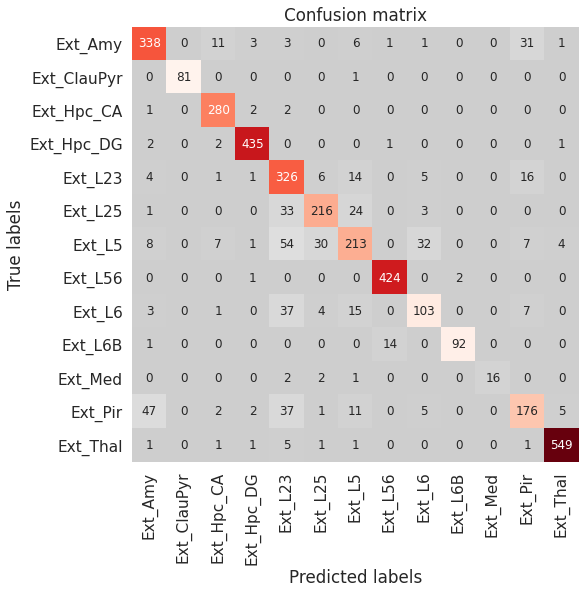

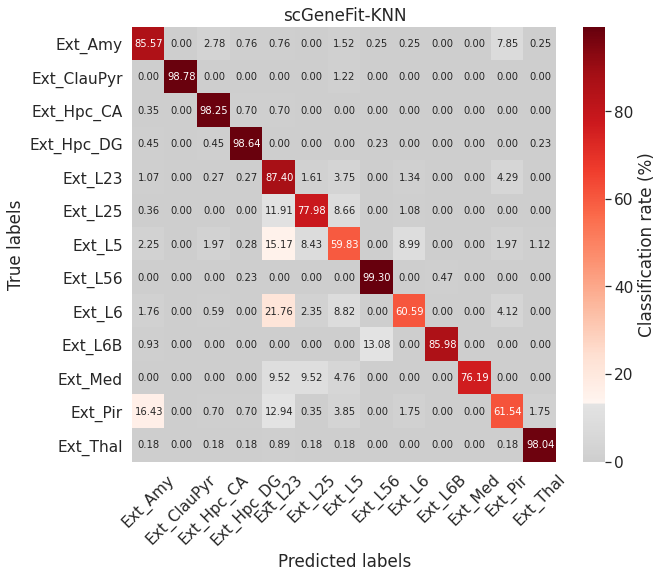

Accuracy: 0.8595238095238096: Misclassification: 0.14047619047619042
              precision    recall  f1-score   support

     Ext_Amy       0.83      0.86      0.84       395
 Ext_ClauPyr       1.00      0.99      0.99        82
  Ext_Hpc_CA       0.92      0.98      0.95       285
  Ext_Hpc_DG       0.98      0.99      0.98       441
     Ext_L23       0.65      0.87      0.75       373
     Ext_L25       0.83      0.78      0.80       277
      Ext_L5       0.74      0.60      0.66       356
     Ext_L56       0.96      0.99      0.98       427
      Ext_L6       0.69      0.61      0.65       170
     Ext_L6B       0.98      0.86      0.92       107
     Ext_Med       1.00      0.76      0.86        21
     Ext_Pir       0.74      0.62      0.67       286
    Ext_Thal       0.98      0.98      0.98       560

    accuracy                           0.86      3780
   macro avg       0.87      0.84      0.85      3780
weighted avg       0.86      0.86      0.86      3780



In [18]:
sf.run_classifiers(obj, group_by="Cell sub annotation", genes=selectedGenes, classifier="KNN", balance=True, title="scGeneFit-KNN")

#### Heatmap selected genes

In [19]:
dict_ens_id = {}
for k, j in zip(obj.var.index.tolist(), obj.var['SYMBOL'].tolist()):
    dict_ens_id[k] = j
    
selectedGenes_t = []
for g in selectedGenes:
    selectedGenes_t.append(dict_ens_id[g])
    
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

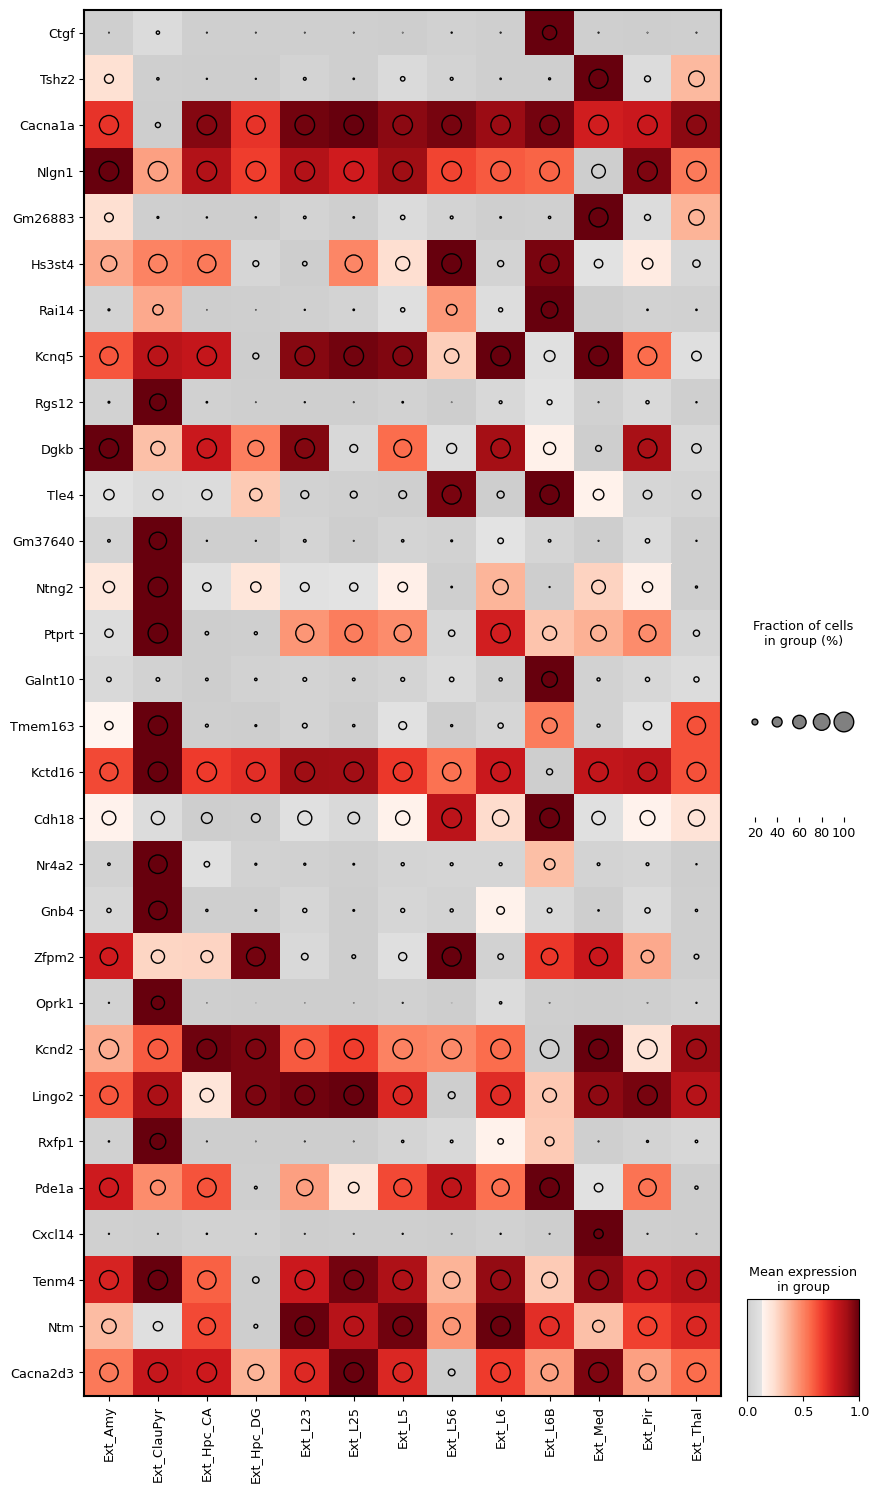

In [20]:
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 11})
ax = sc.pl.DotPlot(obj,
                   selectedGenes_t,
                   gene_symbols = "SYMBOL",
                   groupby="Cell sub annotation",
                   standard_scale='var',
                   use_raw=True,
                   figsize=(10,18),
                   linewidths=2).style(cmap=mymap, color_on='square', grid=True, dot_edge_lw=1)
ax.swap_axes(swap_axes=True)
# ax.show()

ax.savefig("Figures/scGeneFit_top30.pdf")

# Elapsed time

In [21]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 12598 cells


In [22]:
print('Elapsed time (s): ', e-s)

Elapsed time (s):  39450.22806406021
